In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import japanize_matplotlib
import seaborn as sns
from sklearn.datasets import load_iris
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import sys
sys.path.append(
    '/Users/takahashiakira/Documents/DIC/diveintocode-ml/ ml-scratch/model')
sys.path.append(
    '/Users/takahashiakira/Documents/DIC/diveintocode-ml/ ml-scratch/utils')
from split import train_test_split
from decision_region import decision_region2

# 【問題1】ロジスティック回帰のクラスを作成する

## シグモイド関数

コーディング  
シグモイド関数を実装しましょう。  

$$ g(z) = \frac{1}{1+e^{−z}} $$  

正しく動作しているかを確認するために、この関数に-10から10の値を入力したときの出力をプロットしておいてください。

In [2]:
#　シグモイド関数を数式の通り作成
def sigmoid(z):
    return 1 / (1 + (math.e**-z))

Text(0.5, 1.0, 'シグモイド曲線')

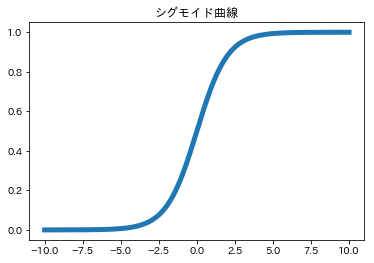

In [3]:
# -10から10までの値を検証
sample = np.arange(-10, 10.01, 0.01)
# 関数を通して出力
g = sigmoid(sample)
# 可視化
sns.lineplot(x=sample, y=g, lw=5)
plt.title('シグモイド曲線')

## 目的関数

以下の数式で表されるロジスティック回帰の目的関数Jを実装してください。この数式には正則化項が含まれています。

$$ h_θ(x) = g(θ^T x).\\ $$

$$ g(z) = \frac{1}{1+e^{−z}}.\\ $$

$$ J(\theta)=  \frac{1}{m}  \sum_{i=1}^{m}[−y^{(i)} log(h_θ(x^{(i)})) − (1−y^{(i)}) log(1−h_θ(x^{(i)}))] + \frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\ $$

$ m $: 入力されるデータの数  
$ h_θ() $ : 仮定関数  
$ x $ : 特徴量ベクトル  
$ θ $ : パラメータベクトル  
$ g() $ : シグモイド関数  
$ x^{(i)} $ : i番目のサンプルの特徴量ベクトル  
$ y^{(i)} $ : i番目のサンプルの正解ラベル  
$ θ_j $ : j番目のパラメータ（重み）  
$ n $ : 特徴量の数  
$ λ $ : 正則化パラメータ

### まずは仮定関数を作成

$$ h_θ(\mathbf{X}) = g(\mathbf{X}\cdot \mathbf{θ}^T).\\ $$

In [4]:
# 仮定関数を作成
def _rogit_hypothesis(X, theta):
    """
    ロジスティック回帰の仮定関数を計算する

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      学習データ
    theta:次の形のndarray, shape (1,n_features)    
    パラメータ

    Returns
    -------
    output :次の形のndarray, shape (n_samples, 1)
      ロジスティック回帰の仮定関数による推定結果

    """
    # outputの算出。線形回帰の入力にそれぞれシグモイド関数を入れるだけ
    output = sigmoid(np.dot(X, theta.T))
    return output

In [5]:
# 動作確認
# X(10,3)のサンプルを作成
X = np.arange(30).reshape(10, 3)
# theta(1,3)
theta = np.random.rand(3).reshape(1, 3)
# 関数の入力
out = _rogit_hypothesis(X, theta)
out

array([[0.71281681],
       [0.97980702],
       [0.99894687],
       [0.99994607],
       [0.99999724],
       [0.99999986],
       [0.99999999],
       [1.        ],
       [1.        ],
       [1.        ]])

確率っぽく出力された

### 目的関数を作成

$$ J(\theta)=  \frac{1}{m}  \sum[−\mathbf{y}\cdot log(output) − (1−\mathbf{y}) log(1−output))] + \frac{λ}{2m}\sum_{j=1}^n
θ^2_j.\\ $$

In [6]:
def cloth_entropy(output, y, l2, theta):
    """
    クロスエントロピーの出力

    Parameters
    ----------
    output :次の形のndarray, shape (n_samples, 1)
      ロジスティック回帰の仮定関数による推定結果
    y : 次の形のndarray, shape (n_samples,)
      正解値
    l2 : float
        正則化
    theta:次の形のndarray, shape (1,n_features)    
    パラメータ

    Returns
    ----------
    mse : numpy.float
      平均二乗誤差
    """
    # サンプル数
    m = len(y)
    # yのreshape
    y = y.reshape(-1, 1)
    # 左側の式のΣを取る前
    errors = -y * np.log(output) - (1 - y) * np.log(1 - output)
    # その合計の平均
    mokuteki = errors.sum() / m
    # 正則化項
    l2_norm = (l2 / (2 * m)) * (np.sum(theta**2))
    # ２つを足す
    syuturyoku = mokuteki + l2_norm

    return syuturyoku

In [7]:
# 仮真値の作成
y = np.concatenate([np.zeros(5), np.ones(5)]).reshape(-1, 1)
cloth_entropy(out, y, 0.001, theta)

3.463489370080235

多分大丈夫

## 最急降下法

In [8]:
def _gradient_descent(X_copy, output, y, l2, coef_):
    """
    最急降下法の計算
    Parameters
    ----------
    X_copy : 次の形のndarray, shape (n_samples,1+n_features)
    説明変数の頭に全て１を加えたもの   
    error : 次の形のndarray, shape (n_samples,)
    誤差
    eturns
    ----------
    coef_ : 次の形のndarray, shape (1,n_features)
    更新後のパラメータ
    """
    errors = output - y
    # 各勾配を計算
    grads = np.dot(errors.T, X_copy) / len(X_copy)
    # それぞれのcoef_を更新する。
    coef_ -= grads
    # 更にcoefが１以上のものに正則化項を加える。
    coef_[:, 1:] -= l2 / len(X_copy) * coef_[:, 1:]
    return coef_, grads

In [9]:
# データをロード
data = load_iris()
# 特徴量をdfとして作成
X = pd.DataFrame(data.data, columns=data.feature_names)
# ターゲットをdfとして作成
y = pd.DataFrame(data.target, columns=['Species'])
# Xとyを結合
df = X.join(y)
df = df[df.Species != 2].reset_index(drop=True)

X = df.drop('Species', axis=1).values
y = df.Species.values

In [10]:
# あやめを使う
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
# Xを複製する
X_copy = X_std.copy()
# all1の定数の追加
X_copy = np.hstack((np.ones((len(X), 1)), X_copy))
# Xの特徴量の
n_features = X_copy.shape[1]
# 仮coef_の作成（初期値はランダム）
coef_ = np.random.rand(1, n_features)
y = y.reshape(-1, 1)

In [11]:
def pred(X, coef_):
    return sigmoid(
        (coef_[:, 0] + np.sum(coef_[:, 1:] * X, axis=1)).reshape(len(X), 1))

In [12]:
out = _rogit_hypothesis(X_copy, coef_)
coef_, grads = _gradient_descent(X_copy, out, y, l2=0.1, coef_=coef_)
y_pred = pred(X_std, coef_)
print(grads)
print(coef_)
print(y_pred)

[[ 0.03779315 -0.08676017  0.16377024 -0.15637251 -0.15235097]]
[[0.30465915 0.31526114 0.00877512 0.97577703 1.01466284]]
[[0.12819954]
 [0.11660946]
 [0.10086402]
 [0.10875034]
 [0.1229801 ]
 [0.23189812]
 [0.12075965]
 [0.13004777]
 [0.09332783]
 [0.10565789]
 [0.15479165]
 [0.12656974]
 [0.09494002]
 [0.0627022 ]
 [0.15480057]
 [0.23584545]
 [0.18720959]
 [0.14975417]
 [0.22587028]
 [0.15931297]
 [0.17254172]
 [0.18471121]
 [0.0807178 ]
 [0.23570635]
 [0.15075783]
 [0.1370217 ]
 [0.18663926]
 [0.14185826]
 [0.13360674]
 [0.12081914]
 [0.12596004]
 [0.20715747]
 [0.12246088]
 [0.15360907]
 [0.12396142]
 [0.10840034]
 [0.14342606]
 [0.10026117]
 [0.08790596]
 [0.13573678]
 [0.1354552 ]
 [0.10692413]
 [0.08820182]
 [0.24800692]
 [0.22929675]
 [0.13080367]
 [0.14478092]
 [0.10253383]
 [0.14844117]
 [0.12238526]
 [0.96812628]
 [0.9593966 ]
 [0.97535228]
 [0.88104077]
 [0.96345973]
 [0.92045628]
 [0.96864944]
 [0.66663246]
 [0.95084863]
 [0.87807747]
 [0.70481046]
 [0.93755093]
 [0.84632

## 実装

In [13]:
class ScratchLogisticRegression():
    """
    ロジスティック回帰のスクラッチ実装

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    fit_intercept : bool
      バイアス項を入れない場合はFalse
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.coef_ : 次の形のndarray, shape (n_features,)
      パラメータ
    self.intercept : 次の形のndarray, shape (1)
      切片
    self.entropy : 次の形のndarray, shape (self._iter,)
      学習用データに対する損失の記録
    self._sum_grad: 次の形のndarray, shape (self._iter,)
      学習注の勾配合計の推移

    """

    def __init__(self,
                 num_iter=1000,
                 lr=1e-2,
                 l2=1e-2,
                 fit_intercept=True,
                 verbose=False):
        # ハイパーパラメータを属性として記録
        self._iter = num_iter
        self._lr = lr
        self._l2 = l2
        self._fit_intercept = fit_intercept
        self._verbose = verbose
        self.coef_ = None  # 仮coef_の作成（初期値はランダム）
        self.r_score = None 
        self.intercept = None

        # エントロピーを記録する配列を用意
        self.entropy = np.zeros(self._iter)

        # 勾配合計を記録する配列を作成
        self._sum_grad = np.zeros(self._iter)

    #　シグモイド関数を数式の通り作成
    def _sigmoid(self, z):
        return 1 / (1 + (math.e**-z))

    # ロジスティック回帰の仮定関数
    def _rogit_hypothesis(self, X):
        """
        ロジスティック回帰の仮定関数を計算する

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
          学習データ
        coef_:次の形のndarray, shape (1,n_features)    
        パラメータ

        Returns
        -------
        output :次の形のndarray, shape (n_samples, 1)
          ロジスティック回帰の仮定関数による推定結果

        """
        # outputの算出。ロジスティック回帰の入力にそれぞれシグモイド関数を入れるだけ
        output = self._sigmoid(np.dot(X, self.coef_.T))
        return output

    # クロスエントロピー関数
    def _cross_entropy(self, output, y):
        """
        クロスエントロピーの出力

        Parameters
        ----------
        output :次の形のndarray, shape (n_samples, 1)
          ロジスティック回帰の仮定関数による推定結果
        y : 次の形のndarray, shape (n_samples,)
          正解値
        l2 : float
            正則化
        coef_:次の形のndarray, shape (1,n_features)    
        パラメータ

        Returns
        ----------
        mse : numpy.float
          平均二乗誤差
        """
        # yのreshape
        y = y.reshape(-1, 1)
        # 左側の式のΣを取る前
        entropy = np.sum(-y * np.log(output) -
                         (1 - y) * np.log(1 - output)) / len(y)
        return entropy

    def _gradient_descent(self, X, output, y):
        """
        最急降下法の計算
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples,n_features)
        説明変数
        error : 次の形のndarray, shape (n_samples,)
        誤差
        returns
        ----------
        coef_ : 次の形のndarray, shape (1,n_features)
        更新後のパラメータ
        """

        errors = output - y  # 予測との誤差を算出
        grads = np.dot(errors.T, X) / len(X)  # Xに誤差をかけて勾配を算出
        self.coef_ -= self._lr * grads  # 勾配に学習率をかけたものをcoef_から引いて更新する
        return grads

    def fit(self, X, y, grad_thre=0.001, l2=1e-2):
        """
        ロジスティック回帰を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            学習用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            学習用データの正解値
        grad_thre : float
            勾配が一定の値以下になったらイテレーションを止めるしきい値
        """
        # エントロピーを記録する配列を用意
        self.entropy = np.zeros(self._iter)
        self._l2 = l2

        # 学習前の準備
        X_copy = X.copy()  # X_copyを作成
        if self._fit_intercept == True:  # バイアス項が必要な場合はXに1を追加
            X_copy = np.hstack((np.ones((len(X), 1)), X_copy))
        self.coef_ = np.random.rand(1, X_copy.shape[1])  # 仮coef_の作成（初期値はランダム）
        y = y.reshape(-1, 1)  # yをリシェイプ

        # 学習開始
        for i in range(self._iter):
            y_pred_prob = self._rogit_hypothesis(X_copy)  # y_predを算出
            self.entropy[i] = self._cross_entropy(
                y_pred_prob, y)  # エントロピーを格納
            grads = self._gradient_descent(X_copy, y_pred_prob,
                                                       y)  # coefを更新

            # 正則化項を追加、fit_interceptによって方法が異なる。
            if self._fit_intercept:
                self.coef_[:, 1:] -= self._lr * (self._l2 / \
                    X_copy.shape[0]) * self.coef_[:, 1:]
            else:
                self.coef_ -= self._lr * (self._l2 / X_copy.shape[0]) * self.coef_

            # 勾配合計をリストに格納
            self._sum_grad[i] = grads.sum()

            # verboseをTrueにした際は学習過程を出力(100回に一回)
            if self._verbose:
                if i % 100 == 0:
                    print('entropy:{:,.3}'.format(self.entropy[i]))

            # 勾配の絶対値がそれなりにひくくなったらイテレーションを止める。
            if abs(grads.sum()) < grad_thre:
                print('grad < {:,.6}'.format(grad_thre))
                print('iter {:,}回で学習終了'.format(i))
                break

            # 最後まで学習した場合も終了メッセージ
            if i == self._iter - 1:
                print('iter {:,}回で学習終了'.format(i))

        # イテレーションが途中で止まった場合は初めに用意していて残った0配列を削除する
        self.entropy = self.entropy[self.entropy != 0]
        self._sum_grad = self._sum_grad[self._sum_grad != 0]

        # 決定係数を取得する
        self.r_score = 1 - (self.entropy[-1] / y.var())

        # interceptをcoefから渡して上げる。
        if self._fit_intercept == True:
            self.intercept = self.coef_[:, 0]


    def predict(self, X):
        """
        ロジスティック回帰を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        pred:  次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """

        # バイアスがある場合とない場合でpred結果分け
        if self._fit_intercept == True:
            pred = np.round(
                self._sigmoid(
                    (self.coef_[:, 0] +
                     np.sum(self.coef_[:, 1:] * X, axis=1)).reshape(len(X),
                                                                    1)))
        else:
            pred = np.round(
                _sigmoid(np.sum((self.coef_ * X), axis=1).reshape(len(X), 1)))
        return pred
    
    def predict_prob(self, X):
        """
        ロジスティック回帰を使い確率を推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
        pred:  次の形のndarray, shape (n_samples, 1)
            ロジスティック回帰による推定結果
        """

        # バイアスがある場合とない場合でpred結果分け
        if self._fit_intercept == True:
            pred = self._sigmoid(
                    (self.coef_[:, 0] +
                     np.sum(self.coef_[:, 1:] * X, axis=1)).reshape(len(X),
                                                                    1))
        else:
            pred = self._sigmoid(np.sum((self.coef_ * X), axis=1).reshape(len(X), 1))
        return pred

In [14]:
scrath = ScratchLogisticRegression()
scrath.fit(X, y)

iter 999回で学習終了


In [15]:
slr = ScratchLogisticRegression()
X1 = X[:, :2]
X_train, X_test, y_train, y_test = train_test_split(
    X1, y, scaler=True)  # train_test_splitの際に標準化をしている

In [16]:
slr.fit(X_train, y_train)

grad < 0.001
iter 871回で学習終了


# 【問題2】学習曲線のプロット

In [17]:
# 学習曲線をプロットする関数
def loss_plot(train_loss,
              val_loss=None,
              title='学習曲線',
              train_label='train_loss',
              test_label='test_loss'):
    # lossのリストを入れればプロットする
    sns.lineplot(data=train_loss, label=train_label, lw=5)
    # もし検証データがあればそれを入れた場合にもプロットする
    if val_loss is not None:
        sns.lineplot(data=val_loss, label=test_label, lw=5)
    plt.title(title)

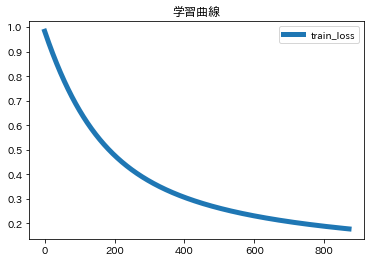

In [18]:
loss_plot(slr.entropy)

# 【問題3】指標値の算出

# 【問題4】決定領域の可視化

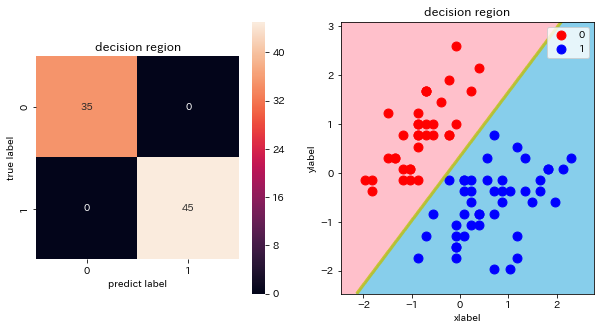

,f1-score,precision,recall,support
0,1.000,1.000,1.000,35.000
1,1.000,1.000,1.000,45.000
micro avg,1.000,1.000,1.000,80.000
macro avg,1.000,1.000,1.000,80.000
weighted avg,1.000,1.000,1.000,80.000


In [19]:
decision_region2(X_train=X_train, y_train=y_train, model=slr)

### sklearnを使った場合

/Users/takahashiakira/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/takahashiakira/.pyenv/versions/anaconda3-2019.03/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


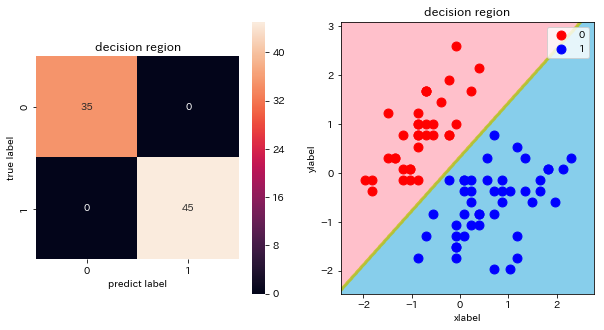

,f1-score,precision,recall,support
0,1.000,1.000,1.000,35.000
1,1.000,1.000,1.000,45.000
micro avg,1.000,1.000,1.000,80.000
macro avg,1.000,1.000,1.000,80.000
weighted avg,1.000,1.000,1.000,80.000


In [20]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
lr.fit(X_train, y_train)
decision_region2(X_train=X_train, y_train=y_train, model=lr)

## OK

# 【問題6】分類と回帰

分類と回帰の違い

分類問題の場合は出力を確率として表現するのでそこが大きく違ってくる。
誤差も同様に、確率として出力された値と、正解ラベルの差を誤差として使用する。正しい確率を高めていく。